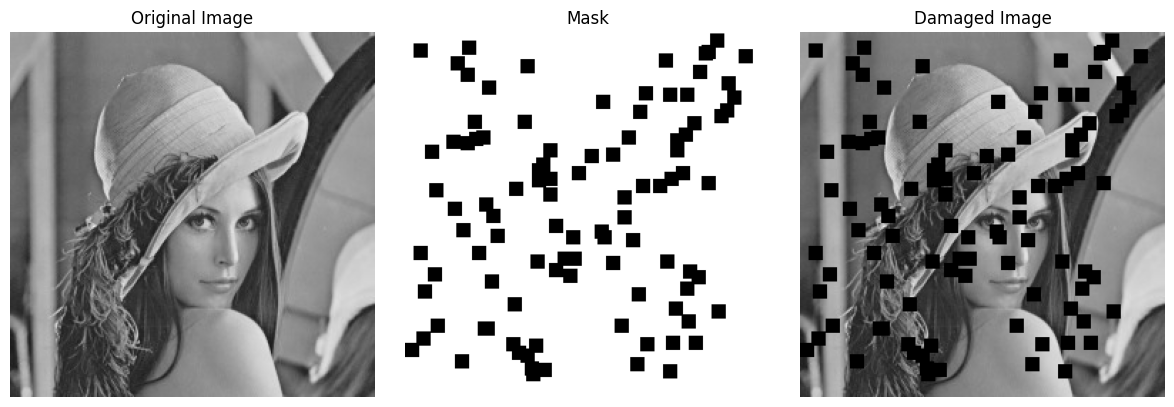

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('lena.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = np.ones(img.shape, dtype=np.uint8) * 255
h, w, _ = img.shape
for _ in range(100):
    x, y = np.random.randint(0, w-20), np.random.randint(0, h-20)
    mask[y:y+10, x:x+10] = 0

noisy_img = cv2.bitwise_and(img, mask)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Damaged Image")
plt.imshow(noisy_img)
plt.axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite('noisy_image.png', cv2.cvtColor(noisy_img, cv2.COLOR_RGB2BGR))
cv2.imwrite('mask.png', cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))


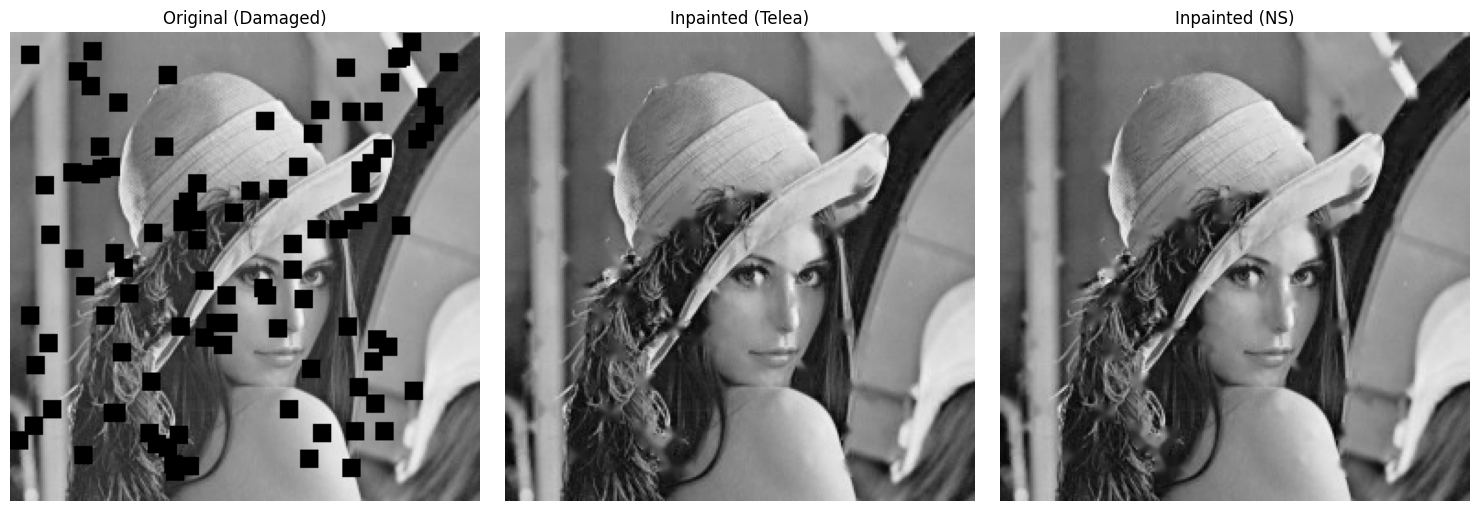

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('noisy_image.png', cv2.IMREAD_GRAYSCALE)

mask = cv2.inRange(img, 0, 1)

inpaint_telea = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

inpaint_ns = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original (Damaged)")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Inpainted (Telea)")
plt.imshow(inpaint_telea, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Inpainted (NS)")
plt.imshow(inpaint_ns, cmap='gray')
plt.axis('off')

plt.tight_layout()+-9
plt.show()


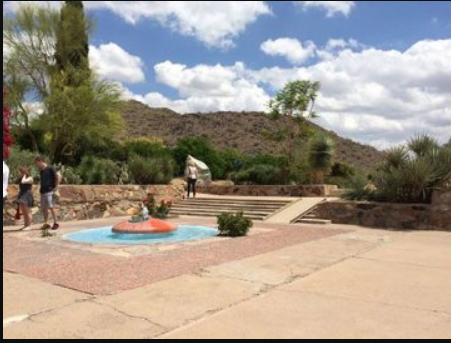

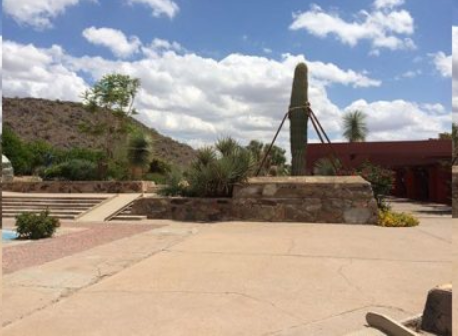

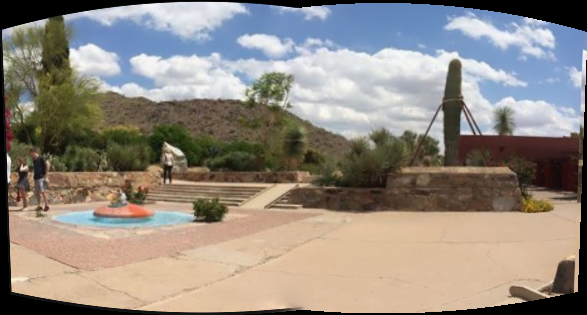

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

images = [cv2.imread(f"image{i}.png") for i in range(1, 3)]

for i, img in enumerate(images, 1):
    cv2_imshow(img)

stitcher = cv2.Stitcher_create()

status, result = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    cv2_imshow(result)
else:
    print("Error during stitching")


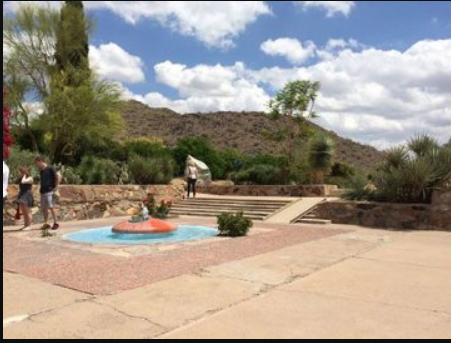

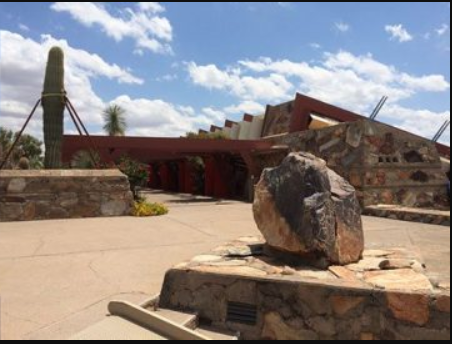

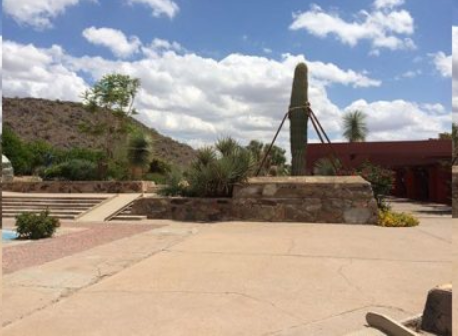

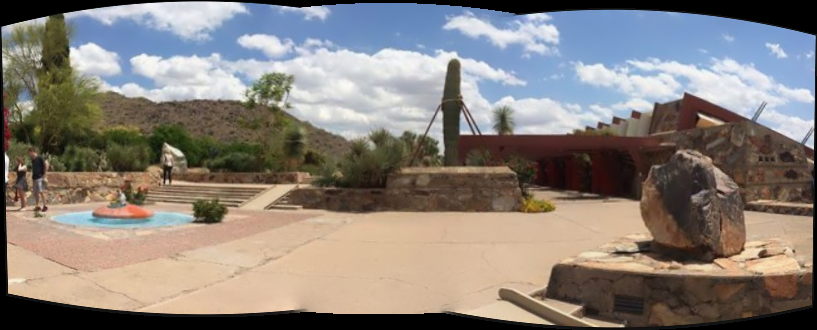

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

images = [cv2.imread(f"image{i}.png") for i in range(1, 4)]

for i, img in enumerate(images, 1):
    cv2_imshow(img)

stitcher = cv2.Stitcher_create(cv2.STITCHER_PANORAMA)

status, panorama = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    cv2_imshow(panorama)
else:
    print("Error during panorama stitching")


Recovered Rotation:
 [[ 0.98958922 -0.14265076 -0.01907727]
 [ 0.14296567  0.98959334  0.01630452]
 [ 0.01655289 -0.01886217  0.99968506]]
Recovered Translation:
 [[ 0.64814877]
 [-0.60863025]
 [ 0.45768153]]


<ipython-input-2-daa59cbcf7ce>:54: RuntimeWarning: overflow encountered in divide
  pts3d = (pts4d_hom[:3, valid_mask] / w[valid_mask]).T  # shape: (N, 3)
<ipython-input-2-daa59cbcf7ce>:54: RuntimeWarning: invalid value encountered in divide
  pts3d = (pts4d_hom[:3, valid_mask] / w[valid_mask]).T  # shape: (N, 3)


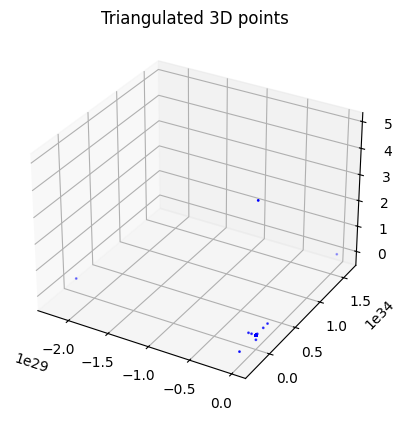

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two grayscale images
img1 = cv2.imread('3.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('4.png', cv2.IMREAD_GRAYSCALE)

# Step 1: Detect keypoints and descriptors using ORB
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Step 2: Match features using Brute-Force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Extract matched keypoint coordinates
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Step 3: Compute the Fundamental Matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Step 4: Define camera intrinsic matrix (you should replace with real intrinsics)
K = np.array([[800, 0, img1.shape[1] // 2],
              [0, 800, img1.shape[0] // 2],
              [0, 0, 1]])

# Step 5: Compute Essential Matrix from matched points and K
E, mask_e = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1.0)

# Step 6: Recover camera pose (Rotation and Translation)
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

print("Recovered Rotation:\n", R)
print("Recovered Translation:\n", t)

# Step 7: Projection matrices
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))  # Camera 1 at origin
P2 = K @ np.hstack((R, t))                         # Camera 2 pose

# Filter inlier points for triangulation
pts1_inliers = pts1[mask_pose.ravel() == 1]
pts2_inliers = pts2[mask_pose.ravel() == 1]

# Step 8: Triangulate points and convert to 3D
pts4d_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)

# Safe conversion from homogeneous to 3D
w = pts4d_hom[3, :]
valid_mask = np.abs(w) > 1e-6  # avoid division by zero
pts3d = (pts4d_hom[:3, valid_mask] / w[valid_mask]).T  # shape: (N, 3)

# Step 9: Plot the 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[:, 0], pts3d[:, 1], pts3d[:, 2], s=1, c='b')
ax.set_title("Triangulated 3D points")
plt.show()


In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import cv2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])




In [ ]:
def add_noise(img):
    noise = np.random.normal(0, 0.1, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

def add_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

x_train_noisy = np.array([add_blur(add_noise(img)) for img in x_train])
x_test_noisy = np.array([add_blur(add_noise(img)) for img in x_test])


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,755 (1.14 MB)

 Trainable params: 298,755 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=128, validation_data=(x_test_noisy, x_test))


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0190 - val_loss: 0.0056
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/ste

In [ ]:
import skimage.metrics as metrics

restored_images = autoencoder.predict(x_test_noisy)

psnr_value = metrics.peak_signal_noise_ratio(x_test, restored_images)
print(f'PSNR: {psnr_value}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
PSNR: 26.584435587839117


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.9794424772262573 | D accuracy: 25.0] [G loss: 1.0982013940811157]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
10 [D loss: 0.9361284971237183 | D accuracy: 19.341856002807617] [G loss: 0.3401314318180084]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
20 [D loss: 1.037125587463379 | D accuracy: 10.016514778137207] [G 

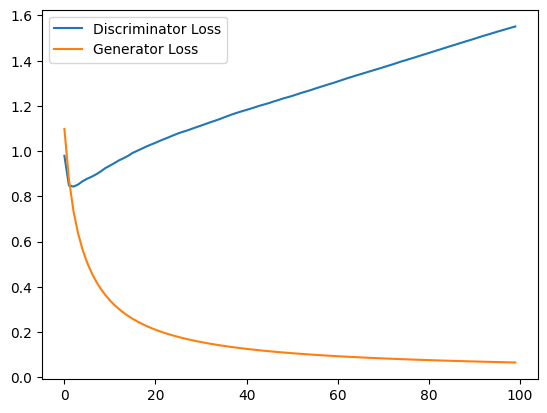

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(28*28, activation='sigmoid'))
    model.add(Reshape((28, 28, 1)))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

latent_dim = 100
img_shape = (28, 28, 1)

generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

epochs = 100
batch_size = 64
half_batch = batch_size // 2

d_losses, g_losses = [], []

for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_images = x_train[idx]
    real_labels = np.ones((half_batch, 1))

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    fake_images = generator.predict(noise)
    fake_labels = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_labels)

    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    if epoch % 10 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.legend()
plt.show()
